In [99]:
# Imports
import shap
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from operator import itemgetter
shap.initjs()

# Preprocess the Data

In [2]:
# Read data
data = pd.read_csv('Dataset-Unicauca-Version2-87Atts-Clean.csv')

In [3]:
# Rename Labels to DataFlow from previous processing that bucketed data usage
data.rename({"labels": "DataFlow"}, axis=1, inplace=True)

In [4]:
# Label Protocol Names to be used as targets for Random Forest Model
lb_make = LabelEncoder()
data["labels"] = lb_make.fit_transform(data["ProtocolName"])
data[["ProtocolName", "labels"]].head(11)
mapped_label_ids = dict(zip(lb_make.classes_,range(len(lb_make.classes_))))

In [5]:
# Drop columns not needed for modelling
data.drop(columns=["Flow.ID"], inplace=True)
data.drop(columns=["ProtocolName"], inplace=True)

In [6]:
# Split Data to train/test
y = data.iloc[:, -1]
data.drop(columns=data.columns[-1], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

# Setup Visualization Labels

In [7]:
# Prepare Interactive Predictive Label Selector for Visualizations
import ipywidgets as widgets
# Create the list of all labels for the drop down list
list_of_labels = y.unique().tolist()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )
# Create a widget for the labels and then display the widget
current_label2 = widgets.Dropdown(options=mapped_label_ids,
                              value=0,
                              description='Select Label:'
                              )

In [8]:
# Function to report accuracy
def print_accuracy(f):
    print("Accuracy = {0}%".format(100 * np.sum(f(X_test) == y_test) / len(y_test)))
    time.sleep(0.5)  # to let the print get out before any progress bars

# Create Simple Random Forest Model

In [9]:
# Random Forest Explainable (only taking the first 5000 records; the entire dataset takes too long to model)
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=20, random_state=0)
rforest.fit(X_train.head(5000), y_train.head(5000))
print_accuracy(rforest.predict)

Accuracy = 84.67699102675202%


# Prepare SHAP Data that Explains the Random Forest

In [ ]:
# explain all the predictions in the test set - NOTE sample may need to be 100
# Use shap.sample on X_train/test like the below because the dataset is too massive; just take a sample
explainer = shap.KernelExplainer(rforest.predict_proba, shap.sample(X_train, nsamples=1000))
shap_values = explainer.shap_values(shap.sample(X_test, nsamples=1000))

# Violin Bee-Summary Plot

This is a standard violin plot but with outliers drawn as points. This gives a more accurate representation of the density out the outliers than a kernel density estimated from so few points. The color represents the average feature value at that position, so red regions have mostly high valued feature values while blue regions have mostly low feature values.

In [21]:
current_label

Dropdown(description='Select Label:', index=1, options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': …

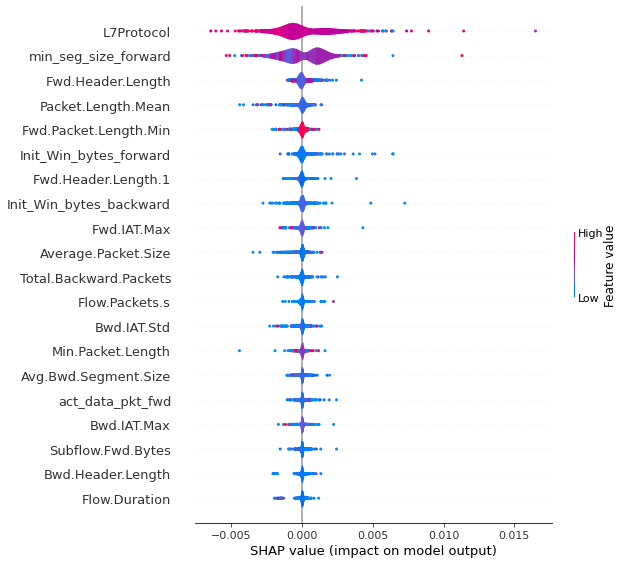

In [23]:
shap.summary_plot(shap_values = shap_values[current_label.value],
                  features = X_test.iloc[0:1000,:],
                  plot_type="violin")

By changing the label to something else we can see what features on the left have a higher impact on the model predicting this label. For example, when predicing the Protocol Name of "99TAXI" we see the feature L7Protocol has little importance on predicting this Protocol. However, the feature Forward Packet Length does.

# Stacked Importance Plot

In [13]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

In [98]:
shap.force_plot(explainer.expected_value[0], shap_values[current_label.value], shap.sample(X_test, nsamples=1000), link='logit')

Again, by changing the predicted label to something else we can see what features are significant and not significant, like from the previous visualization. However, we cal also interact with different features and compairsons from an additional labels on the top and to the left of the visualization. We can see that when both the highlighted features equal a particular value what the other features we are comparing to on top may equal.

# Dependent Correlation Plot

In [15]:
current_label

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

In [16]:
current_label2

Dropdown(description='Select Label:', options={'99TAXI': 0, 'AMAZON': 1, 'APPLE': 2, 'APPLE_ICLOUD': 3, 'APPLE…

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1000,) (2,) 

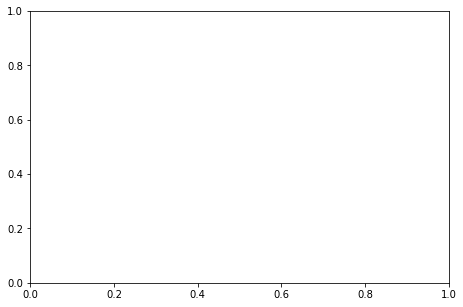

In [17]:
shap.dependence_plot((current_label.value, current_label2.value), shap_values[current_label2.value], shap.sample(X_test, nsamples=1000))

This visualization can show the interactions between two different features. If the features were dependent on each other, there would be an inter-mingling of many colored points. Otherwise, the features are not correlated with each other.

# Visualize a Single Prediction

In [18]:
# Prepare SHAP values
#explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
#shap_values = explainer.shap_values(shap.sample(X_test, nsamples=1000))
#test1 = shap.TreeExplainer(dtree)
#t = test1.shap_values(shap.sample(X_test, nsamples=1000))

In [19]:
# See all our predicted values from our X_test dataset.
explainer.expected_value

array([1.97149104e-02, 1.80760582e-03, 9.09035283e-04, 7.84935330e-04,
       5.46809157e-03, 1.59253637e-03, 2.87889825e-04, 6.71975253e-03,
       1.87190225e-04, 9.69813401e-03, 1.33438387e-02, 2.70490778e-01,
       2.00982371e-04, 1.82311725e-01, 9.63436880e-02, 1.66619885e-01,
       1.24643511e-03, 5.46338480e-04, 1.77853504e-02, 1.97401695e-04,
       3.64843933e-03, 3.11810458e-04, 6.86048775e-04, 1.74179360e-04,
       2.27108446e-03, 1.59911021e-04, 2.04586797e-04, 7.68784497e-03,
       3.68449329e-04, 1.16417757e-01, 5.46690326e-04, 5.59966800e-03,
       1.98847304e-03, 7.05588358e-04, 8.56569049e-03, 5.88208373e-03,
       4.85251904e-02])

In [24]:
# View the features that predicted this label
print("Visualization for predicted label: " + str(int(explainer.expected_value[0])))
shap.force_plot(explainer.expected_value[0], shap_values[35], shap.sample(X_test, nsamples=1000))

Visualization for predicted label: 0


Now interact with the dropdowns at the top to select the feature and see the values of that feature that may predict the label above.

# Non-XAI Visualization

In [87]:
# Get names of columns and importances from the model
cols = list(data.columns)
importances = rforest.feature_importances_

# Map importances to their names
feature_dict = dict(zip(cols, importances))

# Take N largest importances
N = 10
sorted_dict = dict(sorted(feature_dict.items(), key = itemgetter(1), reverse = True)[:N])
sorted_cols = list(sorted_dict.keys())
print(sorted_cols)
sorted_importances = list(sorted_dict.values())
print(sorted_importances)

['L7Protocol', 'Init_Win_bytes_backward', 'Init_Win_bytes_forward', 'min_seg_size_forward', 'Flow.Duration', 'Flow.IAT.Max', 'Min.Packet.Length', 'Fwd.Packets.s', 'Flow.Packets.s', 'act_data_pkt_fwd']
[0.40502873613787405, 0.030244740634522913, 0.02617072406068856, 0.024952425591603548, 0.017224620139604428, 0.015933010449333797, 0.014456543716195699, 0.014331129822577691, 0.013534008603520303, 0.0133187305965237]


<Figure size 720x720 with 0 Axes>

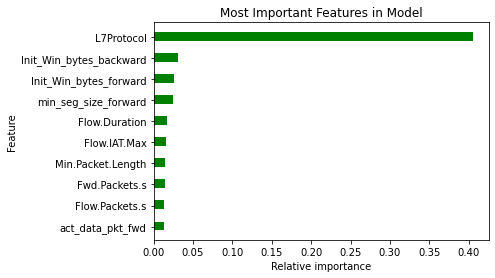

<Figure size 720x720 with 0 Axes>

In [88]:
#plot
fig, ax = plt.subplots()
width = 0.4 # the width of the bars 
ind = np.arange(len(sorted_importances)) # the x locations for the groups
ax.barh(ind, sorted_importances, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(sorted_cols, minor=False)
ax.invert_yaxis()
plt.title("Most Important Features in Model")
plt.xlabel("Relative importance")
plt.ylabel("Feature") 
plt.figure(figsize=(10,10))
# fig.set_size_inches(6.5, 4.5, forward=True)

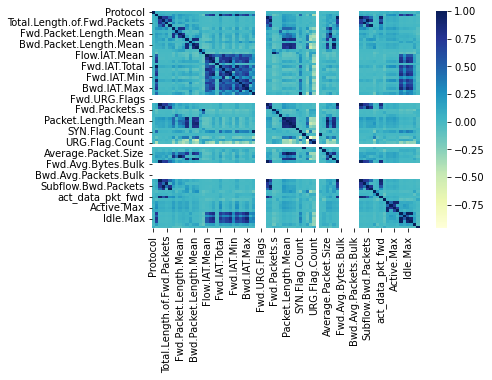

In [102]:
sns.heatmap(data.corr(), cmap = "YlGnBu", annot = False)
plt.show()

In [107]:
non_num_cols = [col for col in data.columns if data[col].dtype == 'O']
num_cols = list(set(data.columns) - set(non_num_cols))
corr = data[num_cols].corr()

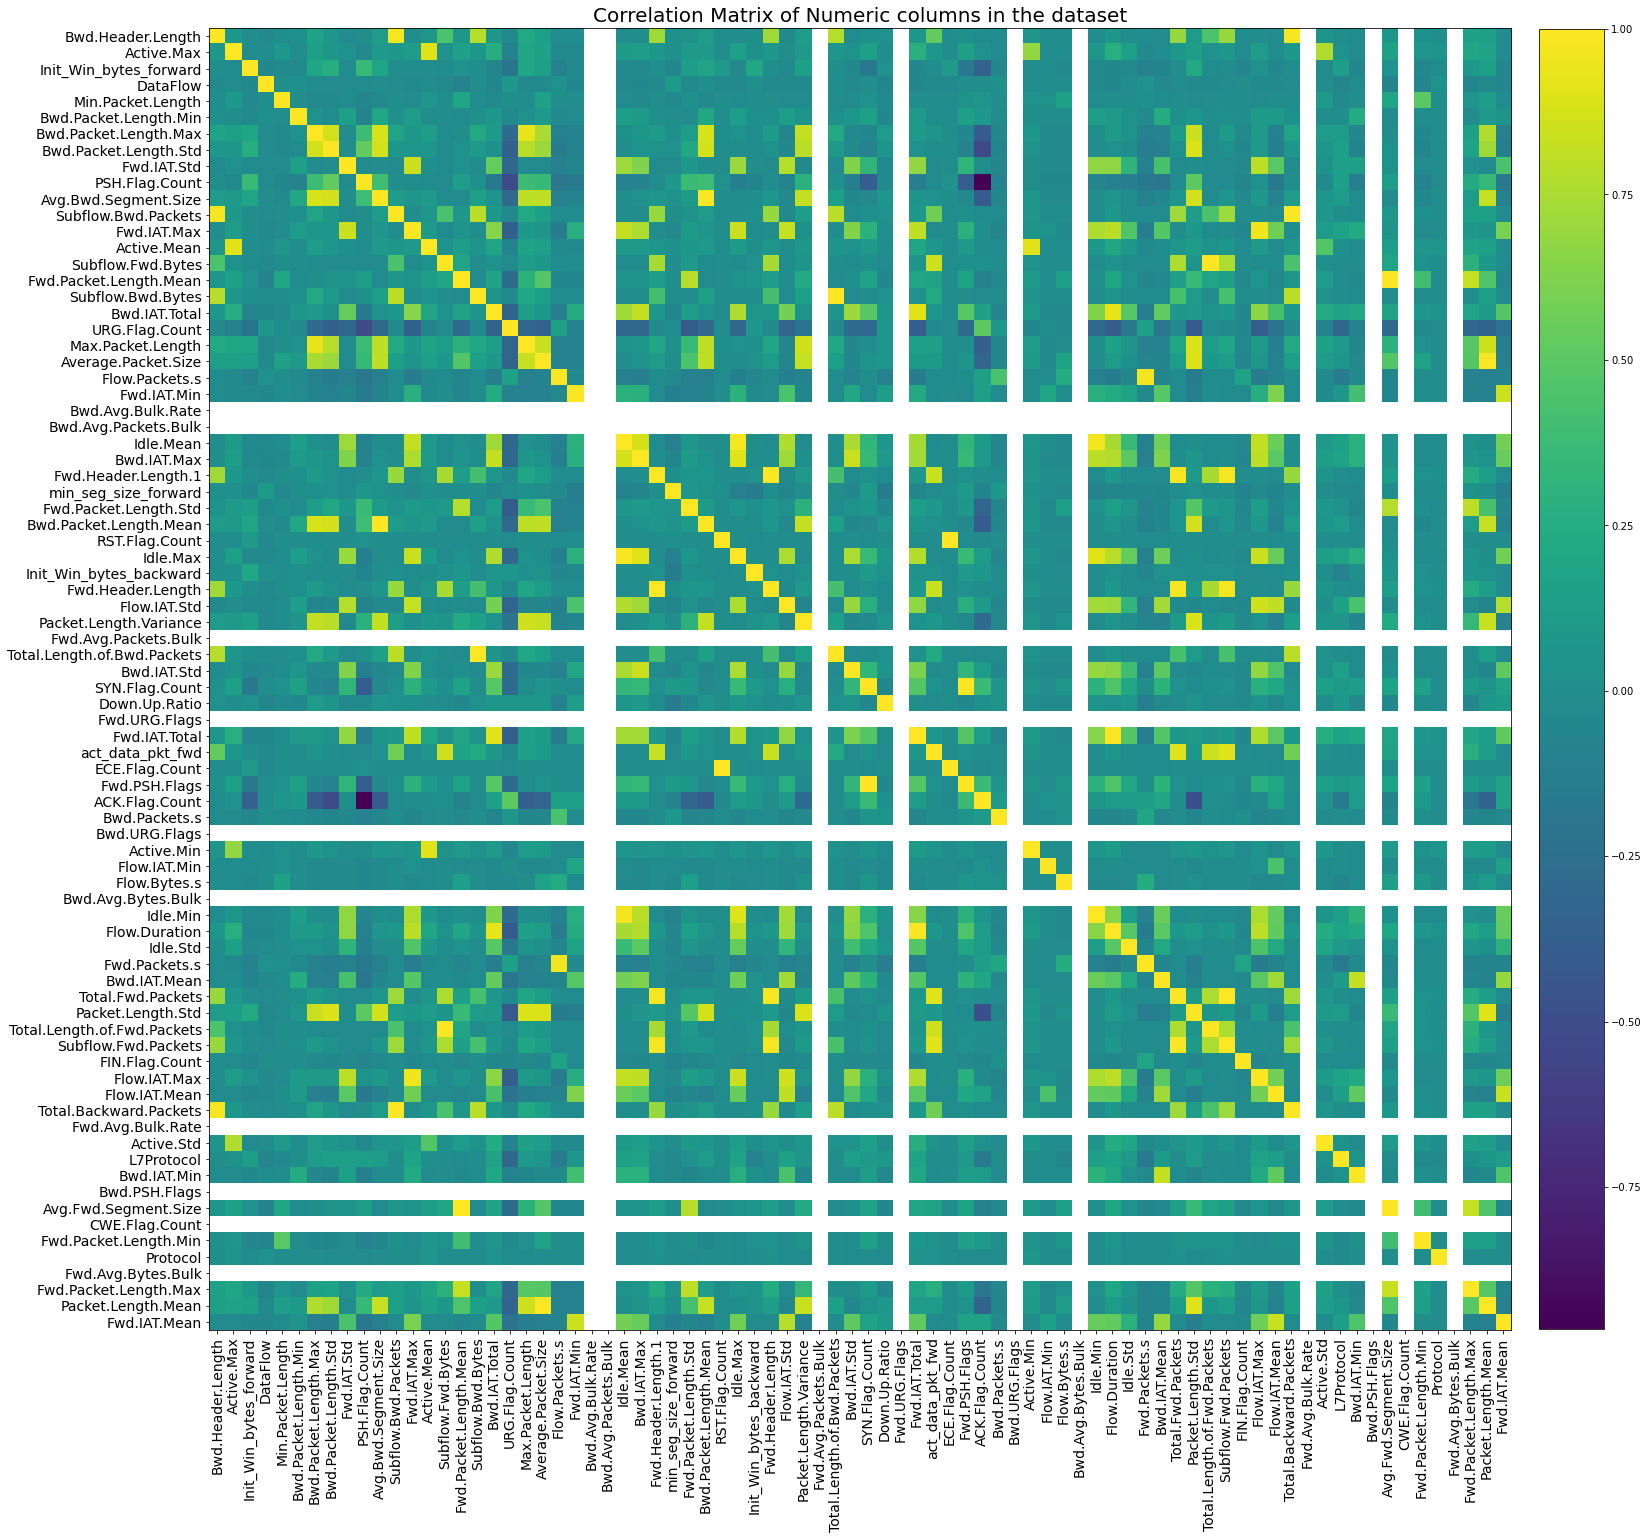

In [108]:
# Correlation on full dataset
f = plt.figure(figsize = (25,25))
plt.matshow(corr, fignum=f.number)
plt.title('Correlation Matrix of Numeric columns in the dataset', fontsize = 20)
plt.xticks(range(len(num_cols)), num_cols, fontsize = 14, rotation = 90)
plt.yticks(range(len(num_cols)), num_cols, fontsize = 14)
plt.gca().xaxis.set_ticks_position('bottom')
cb = plt.colorbar(fraction = 0.0466, pad = 0.02)
cb.ax.tick_params(labelsize=10)
plt.show()

In [110]:
# Correlation Plot on just Facebook data
data.head()

Protocol  Flow.Duration  Total.Fwd.Packets  Total.Backward.Packets  \
0         6          45523                 22                      55   
1         6              1                  2                       0   
2         6              1                  3                       0   
3         6            217                  1                       3   
4         6          78068                  5                       0   

   Total.Length.of.Fwd.Packets  Total.Length.of.Bwd.Packets  \
0                          132                     110414.0   
1                           12                          0.0   
2                          674                          0.0   
3                            0                          0.0   
4                         1076                          0.0   

   Fwd.Packet.Length.Max  Fwd.Packet.Length.Min  Fwd.Packet.Length.Mean  \
0                      6                      6                6.000000   
1                      6                      6                6.000000   
2                    337                      0              224.666667   
3                      0                      0                0.000000   
4                    529                      6              215.200000   

   Fwd.Packet.Length.Std  ...  Active.Mean  Active.Std  Active.Max  \
0               0.000000  ...          0.0         0.0         0.0   
1               0.000000  ...          0.0         0.0         0.0   
2             194.567041  ...          0.0         0.0         0.0   
3               0.000000  ...          0.0         0.0         0.0   
4             286.458898  ...          0.0         0.0         0.0   

   Active.Min  Idle.Mean  Idle.Std  Idle.Max  Idle.Min  L7Protocol  DataFlow  
0         0.0        0.0       0.0       0.0       0.0         131         2  
1         0.0        0.0       0.0       0.0       0.0         131         3  
2         0.0        0.0       0.0       0.0       0.0           7         3  
3         0.0        0.0       0.0       0.0       0.0           7         3  
4         0.0        0.0       0.0       0.0       0.0         131         3  

[5 rows x 80 columns]